# Multi-modal Embedding using CLIP-32

## Imports and Utilities

In [1]:
from sentence_transformers import SentenceTransformer, util, models, InputExample, losses
from PIL import Image
import glob
import torch
from torch.utils.data import DataLoader
import pickle
import zipfile
from IPython.display import display
from IPython.display import Image as IPImage
import pandas as pd
import os
from tqdm.autonotebook import tqdm, trange
import torch
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import numpy as np
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

In [2]:
image_folder = 'images/'
def show_image(img_id, img_folder=image_folder):
    try:
        image_link = img_folder + img_id + '.jpg'
        plt.title("Image")
        plt.xlabel("X pixel scaling")
        plt.ylabel("Y pixels scaling")

        image = mpimg.imread(image_link)
    except:
        image_link = img_folder + img_id + '.png'
        plt.title("Image")
        plt.xlabel("X pixel scaling")
        plt.ylabel("Y pixels scaling")

        image = mpimg.imread(image_link)
    plt.imshow(image)
    plt.show()

In [3]:
import random
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

In [11]:
df = pd.read_csv('data/tweets_subset.csv', index_col='Unnamed: 0').reset_index()
df[df.available].head()

,index,id,skepticism,mainstream,label,text_NL,text_EN,split,available,target,unseen_images
956,956,327027443732983808,False,True,1,"RT @USER : 3D waterkaart , hoe stroomt het wat...","RT @USER : 3D water map , how the water flows ...",test,True,3_327026285966667776,1
1211,1211,375896131127218176,False,True,1,Kom naar de Wilhelminakade R'dam en klim boven...,Come to the Wilhelminakade R'dam and climb abo...,val,True,3_375896131013971968,1
1212,1212,375899134915772416,False,True,1,RT @USER : Kom naar de Wilhelminakade R'dam en...,RT @USER : Come to the Wilhelminakade R'dam an...,val,True,3_375896131013971968,1
1214,1214,375946829881278464,False,True,1,Scholieren klimmen met Jeugdwaterschap naar ni...,Students climb to the water level of their hou...,val,True,3_375946829747089408,0
1215,1215,375946961951539200,False,True,1,RT @USER : Scholieren klimmen met Jeugdwatersc...,RT @USER : Students climb to the water level o...,train,True,3_375946829747089408,0


In [12]:
# We use the original CLIP model for computing image embeddings and English text embeddings
en_model = SentenceTransformer('clip-ViT-B-32')
tokenizer = en_model._first_module().processor.tokenizer

In [13]:
def embed_documents(documents, embedding_model=en_model, convert_to_tensor = True, verbose = False):
    """ Embed a list of n documents/words into an n-dimensional
    matrix of embeddings

    Arguments:
        documents: A list of documents or words to be embedded
        verbose: Controls the verbosity of the process

    Returns:
        Document/words embeddings with shape (n, m) with `n` documents/words
        that each have an embeddings size of `m`
    """
    truncated_docs = [truncate_document(doc) for doc in documents]
    embeddings = embedding_model.encode(truncated_docs, show_progress_bar=verbose, convert_to_tensor=convert_to_tensor)
    return embeddings

def truncate_document(document, tokenizer=tokenizer):
    tokens = tokenizer.encode(document)

    if len(tokens) > 77:
        # Skip the starting token, only include 75 tokens
        truncated_tokens = tokens[1:76]
        document = tokenizer.decode(truncated_tokens)

        # Recursive call here, because the encode(decode()) can have different result
        return truncate_document(document)

    else:
        return document

In [14]:
df['text_EN_trun'] = df['text_EN'].apply(truncate_document)

Token indices sequence length is longer than the specified maximum sequence length for this model (80 > 77). Running this sequence through the model will result in indexing errors


In [15]:
def embed_images(images, verbose=True, batch_size=32, embedding_model=en_model, convert_to_tensor=True):
    if batch_size:
        nr_iterations = int(np.ceil(len(images) / batch_size))

        # Embed images per batch
        embeddings = []
        for i in tqdm(range(nr_iterations), disable=not verbose):
            start_index = i * batch_size
            end_index = (i * batch_size) + batch_size

            images_to_embed = [Image.open(img_name_dict[image]) if (isinstance(image, str) and not str(image)=='nan') 
                               else (Image.new('RGB', (800, 600), color = (255,255,255)) if str(image)=='nan'
                               else image) for image in images[start_index:end_index]]
            img_emb = embedding_model.encode(images_to_embed, show_progress_bar=False, convert_to_tensor=convert_to_tensor)
            embeddings.extend(img_emb.tolist())

            # Close images
            if isinstance(images[0], str):
                for image in images_to_embed:
                    image.close()
        if not convert_to_tensor:
            embeddings = np.array(embeddings)
        else:
            embeddings = torch.tensor(embeddings).to(device='cuda')
    else:
        images_to_embed = [Image.open(filepath) for filepath in images]
        embeddings = embedding_model.encode(images_to_embed, show_progress_bar=False, convert_to_tensor=convert_to_tensor)
    return embeddings

In [16]:
def return_report(labels, preds, ids=[]):
    if len(ids)==0:
        print(metrics.classification_report(labels.cpu(), preds.cpu(), digits=4))
        return metrics.classification_report(labels.cpu(), preds.cpu(), digits=4, output_dict=True)
    else:
        print(metrics.classification_report(labels[torch.tensor(list(ids))].cpu(), preds[torch.tensor(list(ids))].cpu(), digits=4))
        return metrics.classification_report(labels[torch.tensor(list(ids))].cpu(), preds[torch.tensor(list(ids))].cpu(), digits=4, output_dict=True)

def evaluate_dataset_F1(df, preds_all, device = 'cuda', val_set = 'val'):
    preds_all = preds_all.float()
    label_all = torch.tensor(np.array(df['skepticism'])).to(device).float()
    train = df[df['split'] == 'train'].index
    val = df[df['split'] == 'val'].index
    test = df[df['split'] == 'test'].index
    image = df[df['available']].index
    unseen = df[df['unseen_images']==1].index
    
    if val_set=='val':
        temp = val.copy()
    elif val_set=='test':
        temp = test.copy()
    
    a = temp.intersection(image)
    b = temp.difference(image)
    c = temp.intersection(image).intersection(unseen)    
    
    print('Overall Dataset:')
    all_report = return_report(label_all, preds_all)
    
    print('Training Set:')
    train_report = return_report(label_all, preds_all, train)
    
    print('Validation Set:')
    val_report = return_report(label_all, preds_all, temp)
    
    print('Validation Set with both Images and Texts:')
    val_img_report = return_report(label_all, preds_all, a)
    
    print('Validation Set with only Texts:')
    val_txt_report = return_report(label_all, preds_all, b)
    
    print('Validation Set with unseen Images:')
    val_unseen_report = return_report(label_all, preds_all, c)
    
    all_acc = ((label_all==preds_all).sum()/len(preds_all)).item()*100
    train_acc = ((label_all[torch.tensor(list(train))]==preds_all[torch.tensor(list(train))]).sum()/len(train)).item()*100
    val_acc = ((label_all[torch.tensor(list(temp))]==preds_all[torch.tensor(list(temp))]).sum()/len(temp)).item()*100
    val_img_acc = ((label_all[torch.tensor(list((a)))]==preds_all[torch.tensor(list(a))]).sum()/len(a)).item()*100
    val_txt_acc = ((label_all[torch.tensor(list((b)))]==preds_all[torch.tensor(list((b)))]).sum()/len(b)).item()*100
    val_unseen = ((label_all[torch.tensor(list((c)))]==preds_all[torch.tensor(list((c)))]).sum()/len(c)).item()*100
    
    print('''
    Overall Accuracy: {:.2f}
    Training Set Accuracy: {:.2f}
    Validation Set Accuracy: {:.2f}
    Validation Set with both Images and Texts: {:.2f}
    Validation Set with only Texts: {:.2f}
    Validation Set with unseen Images: {:.2f}
    '''.format(all_acc, train_acc, val_acc, val_img_acc, val_txt_acc, val_unseen))
    
    return all_report, train_report, val_report, val_img_report, val_txt_report, val_unseen_report

In [17]:
def evaluate_dataset(df, preds_all, device = 'cuda', val_set = 'val'):
    preds_all = preds_all.float()
    label_all = torch.tensor(np.array(df['skepticism'])).to(device).float()
    #train = torch.tensor(np.array(df_all['split'] == 'train')).to(device).float()
    train = df[df['split'] == 'train'].index
    #val = torch.tensor(np.array(df_all['split'] == 'val')).to(device).float()
    val = df[df['split'] == 'val'].index
    #test = torch.tensor(np.array(df_all['split'] == 'test')).to(device).float()
    test = df[df['split'] == 'test'].index
    #image = torch.tensor(np.array(df_all['available'])).to(device).float()
    image = df[df['available']].index
    #unseen = torch.tensor(np.array(df_all['unseen_images'])).to(device).float()
    unseen = df[df['unseen_images']==1].index
    
    if val_set=='val':
        a = val.intersection(image)
        b = val.difference(image)
        c = val.intersection(image).intersection(unseen)
        val_acc = ((label_all[torch.tensor(list(val))]==preds_all[torch.tensor(list(val))]).sum()/len(val)).item()*100
            
    elif val_set=='test':
        a = test.intersection(image)
        b = test.difference(image)
        c = test.intersection(image).intersection(unseen)
        val_acc = ((label_all[torch.tensor(list(test))]==preds_all[torch.tensor(list(test))]).sum()/len(test)).item()*100
    
    all_acc = ((label_all==preds_all).sum()/len(preds_all)).item()*100
    train_acc = ((label_all[torch.tensor(list(train))]==preds_all[torch.tensor(list(train))]).sum()/len(train)).item()*100
    
    val_img_acc = ((label_all[torch.tensor(list((a)))]==preds_all[torch.tensor(list(a))]).sum()/len(a)).item()*100
    val_txt_acc = ((label_all[torch.tensor(list((b)))]==preds_all[torch.tensor(list((b)))]).sum()/len(b)).item()*100
    val_unseen = ((label_all[torch.tensor(list((c)))]==preds_all[torch.tensor(list((c)))]).sum()/len(c)).item()*100
    
    print('''
    Overall Accuracy: {:.2f}
    Training Set Accuracy: {:.2f}
    Validation Set Accuracy: {:.2f}
    Validation Set with both Images and Texts: {:.2f}
    Validation Set with only Texts: {:.2f}
    Validation Set with unseen Images: {:.2f}
    '''.format(all_acc, train_acc, val_acc, val_img_acc, val_txt_acc, val_unseen))
    
    return all_acc, train_acc, val_acc, val_img_acc, val_txt_acc, val_unseen

## Process Raw Data into Embeddings

Two sentences to compute embeddings

In [18]:
labels = ['Climate change is a very serious issue to pay attention to! We should care about climate change!', 
          'Climate change is not even a real problem to concern about! I do not believe in it!']
lab_emb = en_model.encode(labels, convert_to_tensor=True)

In [19]:
empty_img_emb = embed_images(['nan'])

  0%|          | 0/1 [00:00<?, ?it/s]

In [25]:
empty_img_emb.shape

torch.Size([1, 512])

In [ ]:
txt_emb = embed_documents(list(df['text_EN']), convert_to_tensor=True, verbose=True)

In [22]:
txt_emb.shape

torch.Size([49316, 512])

In [ ]:
img_emb = embed_images(list(df['target']), convert_to_tensor=True)

In [23]:
img_emb.shape

torch.Size([49316, 512])

In [ ]:
import pickle
with open('model_storage/CLIP32/embeddings.pkl', "wb") as fOut:
    pickle.dump({'sentences': list(df['text_EN_trun']), 'txt_emb': txt_emb, 'img_emb': img_emb, 
                 'lab_emb': lab_emb, 'empty_img_emb': empty_img_emb}, fOut, protocol=pickle.HIGHEST_PROTOCOL)

In [87]:
with open('model_storage/CLIP32/embeddings.pkl', "rb") as fIn:
    stored_data = pickle.load(fIn)
    #stored_sentences = stored_data['sentences']
    txt_emb = stored_data['txt_emb']
    img_emb = stored_data['img_emb']
    lab_emb = stored_data['lab_emb']
    empty_img_emb = stored_data['empty_img_emb']

labs = {}
labs['txt_emb'] = lab_emb
labs['img_emb'] = torch.vstack([empty_img_emb] * lab_emb.shape[0])
mul_emb = (img_emb + txt_emb)/2

## Zero-shot Classification

Using Cosine Similarity to make classification

In [88]:
def zero_shot(df_all, model_name='CLIP32', merge = 'average', from_stored_embedding=False, pre_computed = True,
             stored_data='', embedding_model = '', val_set='val'):
    
    if from_stored_embedding:
        folder = 'model_storage/{}/embeddings.pkl'.format(model_name)
        with open(folder, "rb") as fIn:
            stored_data = pickle.load(fIn)
            #stored_sentences = stored_data['sentences']
            txt_emb = stored_data['txt_emb']
            img_emb = stored_data['img_emb']
            lab_emb = stored_data['lab_emb']
    elif pre_computed:
        stored_data = stored_data
        #stored_sentences = stored_data['sentences']
        txt_emb = stored_data['txt_emb']
        img_emb = stored_data['img_emb']
        lab_emb = stored_data['lab_emb']
    else:
        txt_emb = embed_documents(list(df_all['text_EN_trun']), embedding_model=embedding_model, convert_to_tensor=True, verbose=True)
        img_emb = embed_images(list(df_all['target']), embedding_model=embedding_model, convert_to_tensor=True, verbose=True)
        labels = ['Climate change is a very serious issue to pay attention to! We should care about climate change!', 
                  'Climate change is not even a real problem to concern about! I do not believe in it!']
        lab_emb = embedding_model.encode(labels, convert_to_tensor=True)
        with open('model_storage/CLIP/embeddings_re.pkl', "wb") as fOut:
            pickle.dump({'sentences': list(df['text_EN_trun']), 'txt_emb': txt_emb, 'img_emb': img_emb, 'lab_emb': lab_emb}, fOut, protocol=pickle.HIGHEST_PROTOCOL)
    
    if merge == 'average':
        mul_emb = (img_emb + txt_emb)/2
    elif merge == 'max':
        mul_emb = torch.max(img_emb, txt_emb)
    else:
        print("'Merger' input must be one of 'average' or 'max'")
    
    TXT_LAB = util.cos_sim(lab_emb, txt_emb)
    IMG_LAB = util.cos_sim(lab_emb, img_emb)
    MUL_LAB = util.cos_sim(lab_emb, mul_emb)
    
    pred_TXT = torch.argmax(TXT_LAB[:2,:], dim=0).float()
    pred_IMG = torch.argmax(IMG_LAB[:2,:], dim=0).float()
    pred_MUL = torch.argmax(MUL_LAB[:2,:], dim=0).float()
    
    lab = torch.tensor(np.array(df_all['skepticism'])).to('cuda').float()
    
    set_seed_everywhere(42, cuda=True)
    lab_rand = (torch.rand(len(lab))>0.5).float().to('cuda')
    
    print('Using textual embedding only:')
    evaluate_dataset(df_all, pred_TXT, val_set=val_set)
    
    print('Using image embedding only:')
    evaluate_dataset(df_all, pred_IMG, val_set=val_set)
    
    print('Using multi-modal embedding:')
    evaluate_dataset(df_all, pred_MUL, val_set=val_set)
    
    print('Comparing to a random prediction:')
    evaluate_dataset(df_all, lab_rand, val_set=val_set)
    
    print('Test set performance multi-modal:')
    evaluate_dataset(df_all, pred_MUL, val_set='test')
    
    return

In [89]:
zero_shot(df, stored_data = stored_data)

Using textual embedding only:

    Overall Accuracy: 61.66
    Training Set Accuracy: 61.63
    Validation Set Accuracy: 62.58
    Validation Set with both Images and Texts: 74.17
    Validation Set with only Texts: 60.45
    Validation Set with unseen Images: 70.19
    
Using image embedding only:

    Overall Accuracy: 45.92
    Training Set Accuracy: 45.95
    Validation Set Accuracy: 46.59
    Validation Set with both Images and Texts: 68.96
    Validation Set with only Texts: 42.47
    Validation Set with unseen Images: 66.25
    
Using multi-modal embedding:

    Overall Accuracy: 57.28
    Training Set Accuracy: 56.93
    Validation Set Accuracy: 58.33
    Validation Set with both Images and Texts: 75.30
    Validation Set with only Texts: 55.21
    Validation Set with unseen Images: 71.01
    
Comparing to a random prediction:

    Overall Accuracy: 49.64
    Training Set Accuracy: 49.67
    Validation Set Accuracy: 49.99
    Validation Set with both Images and Texts: 48.09
   

## Training an additional MLP

In [82]:
from argparse import Namespace
args = Namespace(
    # Data and Path information
    model_state_file='MLP_classifier.pth',
    save_dir='model_storage/CLIP32/',
    result_dir='results/CLIP32/',
    embedding_size=512,
    early_stopping_criteria=20,
    num_epochs=20,
    seed=42,
    
    # Training hyper parameters
    batch_size=32,
    embedding_type='text',
    fusion_type='average',
    hidden_dim=128, 
    learning_rate=5e-5,
    l2=1e-5,
    dropout_p=0.1,
    
    # Runtime options
    catch_keyboard_interrupt=True,
    device= 'cuda',
    cuda=True,
    verbose=True,
)

In [29]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class MLPClassifier(nn.Module):
    
    def __init__(self, embedding_size, embedding_type, fusion_type, hidden_dim, num_classes, dropout_p, 
                 pretrained_embeddings=None):
        """
        Args:
            embedding_size (int): size of the embedding vectors
            embedding_type (str): type of embedding to be used, can be one of {'text', 'image', 'multi'}
            fusion_type (str): type of fusing multimodal embeddings if embedding_type=='multi', can be one of 
                                {'average', 'concat', 'complex'}
            hidden_dim (int): the size of the hidden dimension
            num_classes (int): the number of classes in classification
            dropout_p (float): a dropout parameter 
            pretrained_embeddings (numpy.array): previously trained embeddings
            
        """
        super(MLPClassifier, self).__init__()

        self.embedding_type = embedding_type
        self.fusion_type = fusion_type
        self._dropout_p = dropout_p
        self.dropout = nn.Dropout(dropout_p)
        #self.prelu = nn.PReLU()
        
        self.fc1 = nn.Linear(embedding_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        
        self.fc_concat = nn.Linear(2*embedding_size, hidden_dim)
        self.fc_complex = nn.Linear(5*embedding_size, 2*embedding_size)

    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (dictionary): a dictionary of input data tensors with embeddings. 
                x_in.shape should be (batch, dataset._max_seq_length)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, num_classes)
        """
        
        # embed and permute so features are channels
        x_embedded = x_in
                
        # logistic regression
        if (not self.embedding_type=='multi') or self.fusion_type=='average':
            intermediate_vector = F.relu(self.dropout(self.fc1(x_embedded)))
            prediction_vector = self.fc2(intermediate_vector)
        elif self.embedding_type=='multi' and self.fusion_type=='concat':
            intermediate_vector = F.relu(self.dropout(self.fc_concat(x_embedded)))
            prediction_vector = self.fc2(intermediate_vector)
        elif self.embedding_type=='multi' and self.fusion_type=='complex':
            first_vector = F.relu(self.dropout(self.fc_complex(x_embedded)))
            intermediate_vector = F.relu(self.dropout(self.fc_concat(first_vector)))
            prediction_vector = self.fc2(intermediate_vector)
        
        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)

        return prediction_vector

In [30]:
class CustomDataset(Dataset):
    def __init__(self, df_all, embeddings):
        self.df = df_all
        self.labels = torch.tensor(np.array(self.df['skepticism'])).to(args.device).float()
        measure_len = lambda context: len(context.split(" "))
        self._max_seq_length = max(map(measure_len, self.df.text_EN_trun)) + 0
        self.embeddings = embeddings
        
        train = torch.tensor(df[df['split'] == 'train'].index)
        self.train_df = self.df[self.df.split=='train']
        self.train_size = len(self.train_df)
        self.train_emb = self.embeddings[train]
        
        val = torch.tensor(df[df['split'] == 'val'].index)
        self.val_df = self.df[self.df.split=='val']
        self.validation_size = len(self.val_df)
        self.val_emb = self.embeddings[val]
                
        test = torch.tensor(df[df['split'] == 'test'].index)
        self.test_df = self.df[self.df.split=='test']
        self.test_size = len(self.test_df)
        self.test_emb = self.embeddings[test]

        self._lookup_dict = {'train': (self.train_df, self.train_size, self.train_emb),
                             'val': (self.val_df, self.validation_size, self.val_emb),
                             'test': (self.test_df, self.test_size, self.test_emb)}

        self.set_split('train')
            
    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe 
        
        Args:
            split (str): one of "train", "val", or "test"
        """
        self._target_split = split
        self._target_df, self._target_size, self._target_emb = self._lookup_dict[split]
        
    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        if len(self) % batch_size==0:
            return len(self) // batch_size
        else:
            return len(self) // batch_size + 1

    def __len__(self):
        return self._target_size

    def __getitem__(self, idx):
        emb = self._target_emb[idx].to(args.device)
        row = self._target_df.iloc[idx]
        label = torch.tensor(row[['mainstream', 'skepticism']].astype(int)).to(args.device)
        
        return {'emb': emb, 
                'label': label}

In [31]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_1_acc_val': 0,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'golden_loss': [],
            'train_loss': [],
            'train_1_acc': [],
            'train_acc': [],
            'val_loss': [],
            'val_1_acc': [],
            'val_acc': [],
            'val_img_txt': [],
            'val_txt_only': [],
            'val_unseen_img': [],
            'test_loss': -1,
            'test_1_acc': -1,
            'test_acc': -1,
            'test_img_txt': -1,
            'test_txt_only': -1,
            'test_unseen_img': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), args.save_dir + args.embedding_type + "_" + args.fusion_type + "_" + args.model_state_file)
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        acc_tm1, acc_t = train_state['val_1_acc'][-2:]

        # If accuracy worsened
        if acc_t <= train_state['early_stopping_best_1_acc_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model from sklearn
            if acc_t > train_state['early_stopping_best_1_acc_val']:
                train_state['early_stopping_best_1_acc_val'] = acc_t
                torch.save(model.state_dict(), args.save_dir + args.embedding_type + "_" + args.fusion_type + "_" + args.model_state_file)
                
            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

In [32]:
def compute_cross_entropy(y_pred, y_target):
    y_target = y_target.cpu().float()
    y_pred = y_pred.cpu().float()
    criterion = nn.BCEWithLogitsLoss()
    return criterion(y_target, y_pred)

def compute_1_accuracy(y_pred, y_target):
    y_target_indices = y_target.max(dim=1)[1]
    y_pred_indices = y_pred.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target_indices).sum().item()
    return n_correct / len(y_pred_indices) * 100

def compute_k_accuracy(y_pred, y_target, k=3):
    y_pred_indices = y_pred.topk(k, dim=1)[1]
    y_target_indices = y_target.max(dim=1)[1]
    n_correct = torch.tensor([y_pred_indices[i] in y_target_indices[i] for i in range(len(y_pred))]).sum().item()
    return n_correct / len(y_pred_indices) * 100

def compute_k_jaccard_index(y_pred, y_target, k=3):
    y_target_indices = y_target.topk(k, dim=1)[1]
    y_pred_indices = y_pred.max(dim=1)[1]
    jaccard = torch.tensor([len(np.intersect1d(y_target_indices[i], y_pred_indices[i]))/
                            len(np.union1d(y_target_indices[i], y_pred_indices[i]))
                            for i in range(len(y_pred))]).sum().item()
    return jaccard / len(y_pred_indices)

def compute_jaccard_index(y_pred, y_target, k=3, multilabel=False):
    
    threshold = 1.0/(k+1)
    threshold_2 = 0.5
    
    if multilabel:
        y_pred_indices = y_pred.gt(threshold_2)
    else:
        y_pred_indices = y_pred.gt(threshold)
    
    y_target_indices = y_target.gt(threshold)
        
    jaccard = ((y_target_indices*y_pred_indices).sum(axis=1)/((y_target_indices+y_pred_indices).sum(axis=1)+1e-8)).sum().item()
    return jaccard / len(y_pred_indices)

In [33]:
def softmax_sensitive(T):
    T = np.exp(T) - np.exp(0) + 1e-9
    if len(T.shape)==1:
        return T/T.sum()
    return  T/(T.sum(axis=1).unsqueeze(1))

def cross_entropy(pred, soft_targets):
    logsoftmax = nn.LogSoftmax(dim=1)
    return torch.mean(torch.sum(- soft_targets * logsoftmax(pred), 1))

# convert a df to tensor to be used in pytorch
def df_to_tensor(df):
    device = args.device
    return torch.from_numpy(df.values).float().to(device)

In [34]:
def prepare_embedding(embeddings, embedding_type, fusion_type):
    '''
    Args:
        embeddings (dictionary): a dictionary of input data tensors with embeddings. 
        embedding_type (str): type of embedding to be used, can be one of {'text', 'image', 'multi'}
        fusion_type (str): type of fusing multimodal embeddings if embedding_type=='multi', can be one of 
                        {'average', 'concat', 'complex'}'''
    if embedding_type=='text':
        x_embedded = embeddings['txt_emb']
    elif embedding_type=='image':
        x_embedded = embeddings['img_emb']
    elif embedding_type=='multi':
        if fusion_type=='average':
            x_embedded = (embeddings['txt_emb']+embeddings['img_emb'])/2
        elif fusion_type=='concat':
            x_embedded = torch.hstack([embeddings['txt_emb'], embeddings['img_emb']])
        elif fusion_type=='complex':
            txt_emb = embeddings['txt_emb']
            img_emb = embeddings['img_emb']
            x_embedded = torch.hstack([txt_emb, img_emb, txt_emb+img_emb, txt_emb-img_emb, txt_emb*img_emb])
        else:
            print('fusion_type is not supported')
    else:
        print('embedding_type is not supported')
        
    return x_embedded

In [35]:
def initialization(df, stored_data):
    set_seed_everywhere(args.seed, args.cuda)
    embeddings = prepare_embedding(stored_data, args.embedding_type, args.fusion_type)
    dataset = CustomDataset(df, embeddings)
    
    classifier = MLPClassifier(embedding_size=args.embedding_size, 
                        hidden_dim=args.hidden_dim, 
                        embedding_type=args.embedding_type, 
                        fusion_type=args.fusion_type,
                        num_classes=len(labels), 
                        dropout_p=args.dropout_p).to(args.device)
    
    return embeddings, dataset, classifier

In [36]:
def write_train_state_evaluation(classifier, embeddings, train_state, df):
    preds_all = classifier(embeddings).argmax(dim=1)
    _, train_acc, val_acc, val_img_acc, val_txt_acc, val_unseen = evaluate_dataset(df, preds_all)
    
    train_state['train_acc'].append(train_acc)
    train_state['val_acc'].append(val_acc)
    train_state['val_img_txt'].append(val_img_acc)
    train_state['val_txt_only'].append(val_txt_acc)
    train_state['val_unseen_img'].append(val_unseen)
    
    return train_state

In [37]:
def training_loop(df, stored_data, labs=None, verbose=True):
    
    embeddings, dataset, classifier = initialization(df, stored_data)
    if labs:
        lab_embeddings = prepare_embedding(labs, args.embedding_type, args.fusion_type)
    classifier = classifier.to(args.device)

    loss_func = cross_entropy
    optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate, weight_decay=args.l2)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                               mode='min', factor=0.5,
                                               patience=1)
    train_state = make_train_state(args)
    
    print('Using {} embedding with {} fusion method'.format(args.embedding_type, args.fusion_type))
    
    set_seed_everywhere(args.seed, cuda=True)
    train_state = write_train_state_evaluation(classifier, embeddings, train_state, df)
    
    set_seed_everywhere(args.seed, cuda=True)
    try:
        for epoch_index in trange(args.num_epochs, desc="Epoch", disable=not args.verbose):
            train_state['epoch_index'] = epoch_index

            # Iterate over training dataset

            # setup: batch generator, set loss and acc to 0, set train mode on
            dataset.set_split('train')
            train_dataloader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)
            
            running_loss = 0.0
            running_1_acc = 0.0
            classifier.train()

            for batch_index, batch_dict in enumerate(train_dataloader):

                # step 1. zero the gradients
                optimizer.zero_grad()

                # step 2. get the data compute fuzzy labels
                X = batch_dict['emb']
                y = batch_dict['label']

                size = y.shape[0]

                # step 3. compute the output
                y_pred = classifier(X)

                # step 4. compute the loss
                loss = loss_func(y_pred, y)
                loss_t = loss.item()

                running_loss = (running_loss * batch_index * args.batch_size + loss_t * size)/(batch_index * args.batch_size + size)
                
                # step 5. use loss to produce gradients
                loss.backward()

                # step 6. use optimizer to take gradient step
                optimizer.step()

                # -----------------------------------------
                # compute the accuracies
                acc_1_t = compute_1_accuracy(y_pred, y)
                running_1_acc = (running_1_acc * batch_index * args.batch_size + acc_1_t * size)/(batch_index * args.batch_size + size)
            
            if labs:
                optimizer.zero_grad()
                y_pred = classifier(lab_embeddings)
                y = torch.tensor([[1,0], [0,1]]).to(args.device)
                loss = loss_func(y_pred, y)
                loss.backward()
                optimizer.step()
                train_state['golden_loss'].append(loss.item())
            else:
                train_state['golden_loss'].append('not implemented')
            
            train_state['train_loss'].append(running_loss)
            train_state['train_1_acc'].append(running_1_acc)

            # Iterate over val dataset

            # setup: batch generator, set loss and acc to 0; set eval mode on

            dataset.set_split('val')
            val_dataloader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)

            running_loss = 0.0
            running_1_acc = 0.0
            classifier.eval()

            for batch_index, batch_dict in enumerate(val_dataloader):

                # step 2. get the data compute fuzzy labels
                X = batch_dict['emb']
                y = batch_dict['label']
                size = y.shape[0]

                # step 3. compute the output
                y_pred = classifier(X)

                # step 4. compute the loss
                loss = loss_func(y_pred, y)
                loss_t = loss.item()
                running_loss = (running_loss * batch_index * args.batch_size + loss_t * size)/(batch_index * args.batch_size + size)

                # -----------------------------------------
                # compute the accuracies
                acc_1_t = compute_1_accuracy(y_pred, y)
                running_1_acc = (running_1_acc * batch_index * args.batch_size + acc_1_t * size)/(batch_index * args.batch_size + size)

            train_state['val_loss'].append(running_loss)
            train_state['val_1_acc'].append(running_1_acc)

            train_state = write_train_state_evaluation(classifier, embeddings, train_state, df)
            
            print('Current Running Accuracy Training Set: {:.2f}, Validation Set: {:.2f}, Golden Set: {:.2f}'.format(train_state['train_1_acc'][-1], train_state['val_1_acc'][-1], train_state['golden_loss'][-1]))

            train_state = update_train_state(args=args, model=classifier, train_state=train_state)

            scheduler.step(train_state['val_loss'][-1])

            if train_state['stop_early']:
                break

            with open(args.save_dir + args.embedding_type + "_" + args.fusion_type + "_" + 'train_state.p', 'wb') as fp:
                pickle.dump(train_state, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
    except KeyboardInterrupt:
        print("Exiting loop")
        pass
    
    return train_state

In [38]:
def experiment(df, stored_data, labs = None, hyperdict={}):
    emb_types = ['text', 'image', 'multi']
    fusion_types = ['average', 'concat', 'complex']
    combi = {(a,b) if a=='multi' else (a, fusion_types[0]) for a in emb_types for b in fusion_types}
    
    for key in combi:
        print(key)
        args.embedding_type = key[0]
        args.fusion_type = key[1]
        if not key in hyperdict:
            train_state = training_loop(df, stored_data, labs=labs)
            hyperdict[key] = train_state
            
        with open(args.save_dir+'hyperdict.p', 'wb') as fp:
            pickle.dump(hyperdict,fp, protocol=pickle.HIGHEST_PROTOCOL)    

In [39]:
def demonstration(hyperdict):
    emb_types = ['text', 'image', 'multi']
    fusion_types = ['average', 'concat', 'complex']
    metrics = ['train_acc', 'val_acc', 'val_img_txt', 'val_txt_only', 'val_unseen_img']
    combi = {(a,b) if a=='multi' else (a, fusion_types[0]) for a in emb_types for b in fusion_types}
    
    for m in metrics:
        print(m)
        for key in combi:
            train_state = hyperdict[key]
            pd.Series(train_state[m]).plot(label=str(key))
            plt.legend()
        plt.show()

In [40]:
def statistics(hyperdict, stored_data, df, labs=None, subfolder = ''):
    emb_types = ['text', 'image', 'multi']
    fusion_types = ['average', 'concat', 'complex']
    combi = {(a,b) if a=='multi' else (a, fusion_types[0]) for a in emb_types for b in fusion_types}
    train = df[df['split'] == 'train'].index
    val = df[df['split'] == 'val'].index
    results = {}
    
    for key in combi:
        print(key)
        print()
        results[key] = {}
        args.embedding_type = key[0]
        args.fusion_type = key[1]
        classifier = MLPClassifier(embedding_size=args.embedding_size, 
                        hidden_dim=args.hidden_dim, 
                        embedding_type=args.embedding_type, 
                        fusion_type=args.fusion_type,
                        num_classes=len(labels), 
                        dropout_p=args.dropout_p).to(args.device)
        classifier.load_state_dict(torch.load(args.save_dir + subfolder + args.embedding_type + "_" + args.fusion_type + "_" + args.model_state_file, map_location=torch.device('cpu')))
        classifier.eval()
        y = F.softmax(classifier(prepare_embedding(stored_data, args.embedding_type, args.fusion_type)), dim=1)
        pd.DataFrame(y.cpu().detach().numpy()).to_csv(args.save_dir + subfolder + args.embedding_type + "_" + args.fusion_type + "_" +'prediction.csv')
        
        conf, pred = y.max(dim=1)
        pd.Series(conf.cpu().detach().numpy()).hist()
        
        results[key]['performance']={}
        
        print('Validation Set:')
        results[key]['performance']['val'] = evaluate_dataset(df, pred)
        
        print('Test Set:')
        results[key]['performance']['test'] = evaluate_dataset(df, pred, val_set='test')
        
        if labs:
            print('Prediction for Golden Sentences:')
            print(F.softmax(classifier(prepare_embedding(labs, args.embedding_type, args.fusion_type)), dim=1).cpu().detach().numpy())
            results[key]['golden'] = F.softmax(classifier(prepare_embedding(labs, args.embedding_type, args.fusion_type)), dim=1).cpu().detach().numpy()
            print()
        
        print('Full Dataset:')
        print(pd.Series(conf.cpu().detach().numpy()).describe())
        print('Training Set:')
        print(pd.Series(conf[train].cpu().detach().numpy()).describe())
        print('Validation Set:')
        print(pd.Series(conf[val].cpu().detach().numpy()).describe())
        plt.show()
        
    return results

In [47]:
def statistics_F1(hyperdict, stored_data, df, labs=None, subfolder = ''):
    emb_types = ['text', 'image', 'multi']
    fusion_types = ['average', 'concat', 'complex']
    combi = {(a,b) if a=='multi' else (a, fusion_types[0]) for a in emb_types for b in fusion_types}
    train = df[df['split'] == 'train'].index
    val = df[df['split'] == 'val'].index
    results = {}
    
    for key in combi:
        print(key)
        print()
        results[key] = {}
        args.embedding_type = key[0]
        args.fusion_type = key[1]
        classifier = MLPClassifier(embedding_size=args.embedding_size, 
                        hidden_dim=args.hidden_dim, 
                        embedding_type=args.embedding_type, 
                        fusion_type=args.fusion_type,
                        num_classes=len(labels), 
                        dropout_p=args.dropout_p).to(args.device)
        classifier.load_state_dict(torch.load(args.save_dir + subfolder + args.embedding_type + "_" + args.fusion_type + "_" + args.model_state_file, map_location=torch.device('cpu')))
        classifier.eval()
        y = F.softmax(classifier(prepare_embedding(stored_data, args.embedding_type, args.fusion_type)), dim=1)
        #pd.DataFrame(y.cpu().detach().numpy()).to_csv(args.result_dir + subfolder + args.embedding_type + "_" + args.fusion_type + "_" +'prediction.csv')
        
        conf, pred = y.max(dim=1)
        pd.Series(conf.cpu().detach().numpy()).hist()
        
        results[key]['performance']={}
        
        print('Validation Set:')
        results[key]['performance']['val'] = evaluate_dataset_F1(df, pred)
        
        print('Test Set:')
        results[key]['performance']['test'] = evaluate_dataset_F1(df, pred, val_set='test')
        
        if labs:
            print('Prediction for Golden Sentences:')
            print(F.softmax(classifier(prepare_embedding(labs, args.embedding_type, args.fusion_type)), dim=1).cpu().detach().numpy())
            results[key]['golden'] = F.softmax(classifier(prepare_embedding(labs, args.embedding_type, args.fusion_type)), dim=1).cpu().detach().numpy()
            print()
        
        print('Full Dataset:')
        print(pd.Series(conf.cpu().detach().numpy()).describe())
        print('Training Set:')
        print(pd.Series(conf[train].cpu().detach().numpy()).describe())
        print('Validation Set:')
        print(pd.Series(conf[val].cpu().detach().numpy()).describe())
        plt.show()
        
    return results

In [ ]:
hyperdict = {}
experiment(df, stored_data, labs, hyperdict)

## Performance on Trained Models

In [42]:
perform_results = {}
for o in ['O1', 'O2']:
    perform_results[o] = {}

In [43]:
with open(args.save_dir+'001/hyperdict.p', 'rb') as fp:
    hyperdict = pickle.load(fp)

train_acc


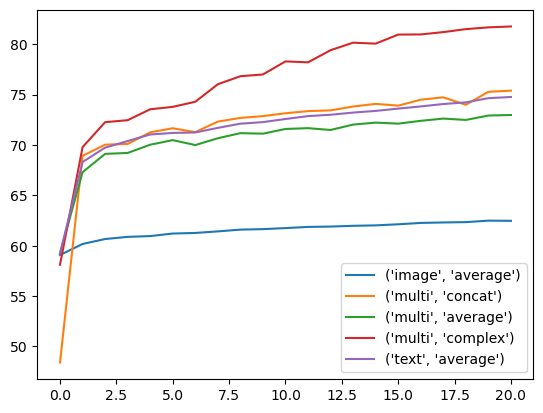

val_acc


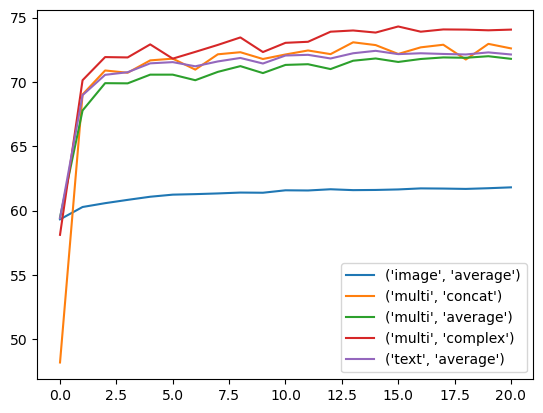

val_img_txt


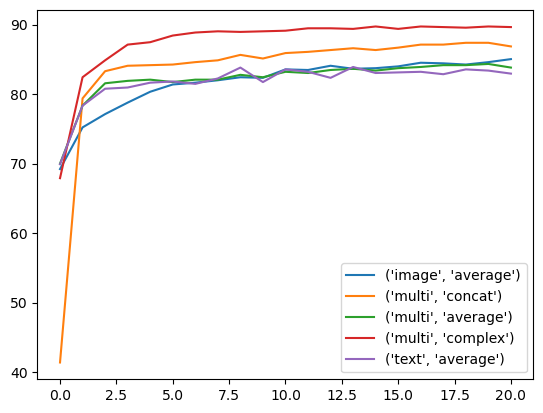

val_txt_only


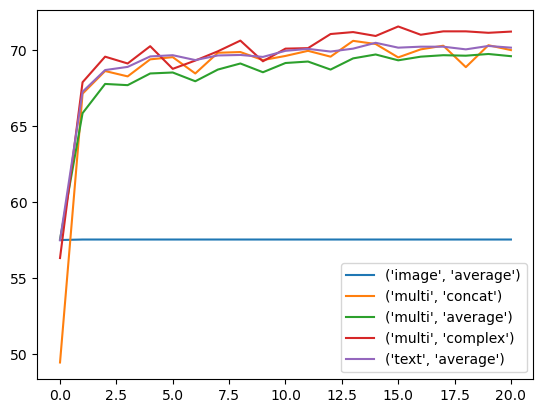

val_unseen_img


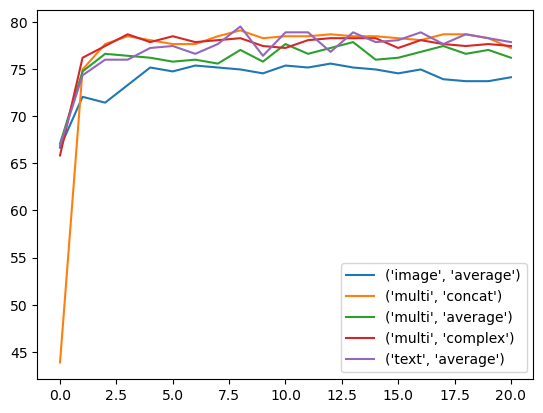

In [44]:
demonstration(hyperdict)

('image', 'average')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.6135    0.9901    0.7575     29306
         1.0     0.8562    0.0863    0.1568     20010

    accuracy                         0.6234     49316
   macro avg     0.7348    0.5382    0.4572     49316
weighted avg     0.7120    0.6234    0.5138     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.6134    0.9921    0.7581     20463
         1.0     0.8870    0.0899    0.1633     14058

    accuracy                         0.6247     34521
   macro avg     0.7502    0.5410    0.4607     34521
weighted avg     0.7248    0.6247    0.5159     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.6110    0.9852    0.7542      4400
         1.0     0.7848    0.0791    0.1437      2997

    accuracy                         0.6181      7397
   macro avg     0.6979    0.5322    0.4490

C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metr

              precision    recall  f1-score   support

         0.0     0.6135    0.9901    0.7575     29306
         1.0     0.8562    0.0863    0.1568     20010

    accuracy                         0.6234     49316
   macro avg     0.7348    0.5382    0.4572     49316
weighted avg     0.7120    0.6234    0.5138     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.6134    0.9921    0.7581     20463
         1.0     0.8870    0.0899    0.1633     14058

    accuracy                         0.6247     34521
   macro avg     0.7502    0.5410    0.4607     34521
weighted avg     0.7248    0.6247    0.5159     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.6161    0.9856    0.7582      4443
         1.0     0.7793    0.0765    0.1393      2955

    accuracy                         0.6225      7398
   macro avg     0.6977    0.5310    0.4487      7398
weighted avg     0.6813    0.6225    0.5110 

C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metr

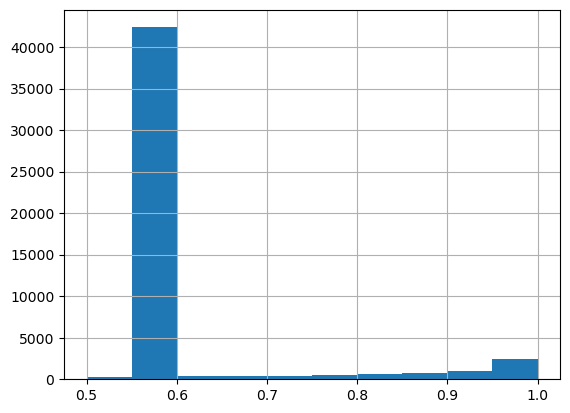

('multi', 'concat')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.7998    0.7364    0.7668     29306
         1.0     0.6541    0.7301    0.6900     20010

    accuracy                         0.7338     49316
   macro avg     0.7270    0.7332    0.7284     49316
weighted avg     0.7407    0.7338    0.7356     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.8023    0.7410    0.7704     20463
         1.0     0.6607    0.7342    0.6955     14058

    accuracy                         0.7382     34521
   macro avg     0.7315    0.7376    0.7330     34521
weighted avg     0.7446    0.7382    0.7399     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.7982    0.7327    0.7641      4400
         1.0     0.6498    0.7281    0.6867      2997

    accuracy                         0.7308      7397
   macro avg     0.7240    0.7304    0.7254 

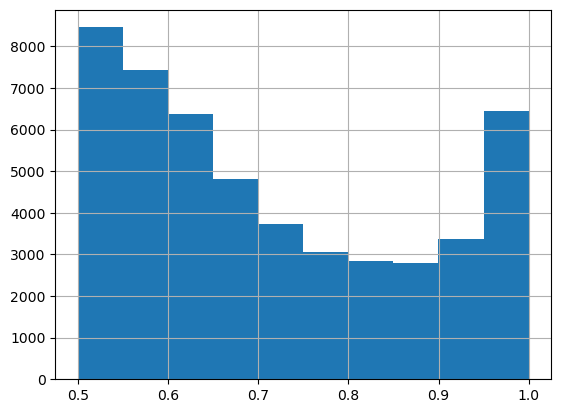

('multi', 'average')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.7716    0.7637    0.7677     29306
         1.0     0.6591    0.6690    0.6640     20010

    accuracy                         0.7253     49316
   macro avg     0.7154    0.7163    0.7158     49316
weighted avg     0.7260    0.7253    0.7256     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.7737    0.7678    0.7708     20463
         1.0     0.6658    0.6731    0.6694     14058

    accuracy                         0.7293     34521
   macro avg     0.7197    0.7205    0.7201     34521
weighted avg     0.7298    0.7293    0.7295     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.7688    0.7570    0.7629      4400
         1.0     0.6511    0.6657    0.6583      2997

    accuracy                         0.7200      7397
   macro avg     0.7099    0.7114    0.7106

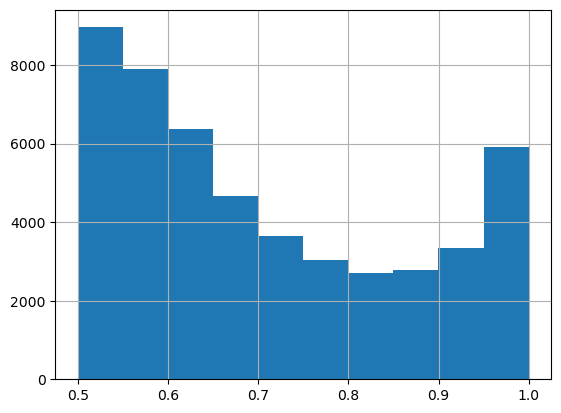

('multi', 'complex')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.8454    0.7854    0.8143     29306
         1.0     0.7153    0.7896    0.7506     20010

    accuracy                         0.7871     49316
   macro avg     0.7803    0.7875    0.7824     49316
weighted avg     0.7926    0.7871    0.7884     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.8655    0.8038    0.8335     20463
         1.0     0.7413    0.8182    0.7778     14058

    accuracy                         0.8097     34521
   macro avg     0.8034    0.8110    0.8057     34521
weighted avg     0.8149    0.8097    0.8108     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.8041    0.7511    0.7767      4400
         1.0     0.6669    0.7314    0.6976      2997

    accuracy                         0.7431      7397
   macro avg     0.7355    0.7413    0.7372

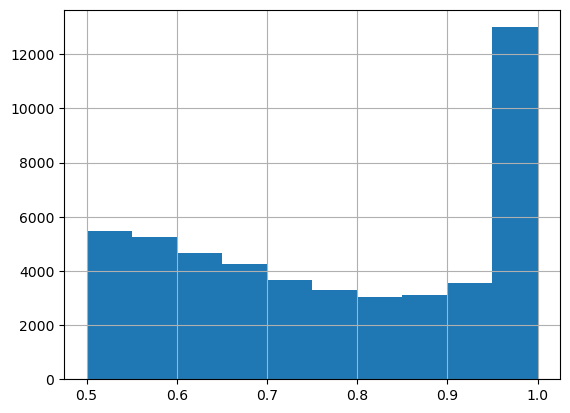

('text', 'average')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.7881    0.7450    0.7659     29306
         1.0     0.6542    0.7066    0.6794     20010

    accuracy                         0.7294     49316
   macro avg     0.7211    0.7258    0.7226     49316
weighted avg     0.7338    0.7294    0.7308     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.7906    0.7495    0.7695     20463
         1.0     0.6610    0.7111    0.6852     14058

    accuracy                         0.7339     34521
   macro avg     0.7258    0.7303    0.7273     34521
weighted avg     0.7379    0.7339    0.7352     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.7852    0.7384    0.7611      4400
         1.0     0.6468    0.7034    0.6739      2997

    accuracy                         0.7242      7397
   macro avg     0.7160    0.7209    0.7175 

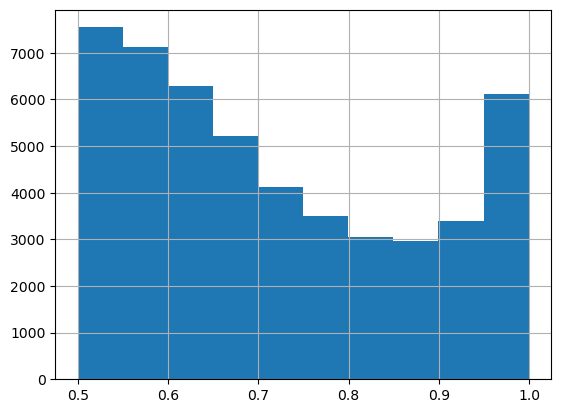

In [46]:
perform_results['O1'] = statistics_F1(hyperdict, stored_data, df, labs, subfolder='001/')

In [48]:
with open(args.save_dir+'002/hyperdict.p', 'rb') as fp:
    hyperdict = pickle.load(fp)

train_acc


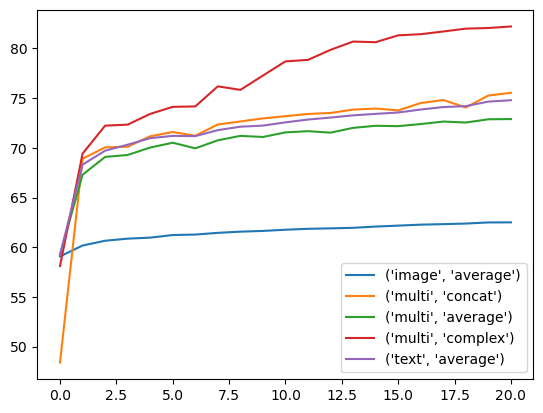

val_acc


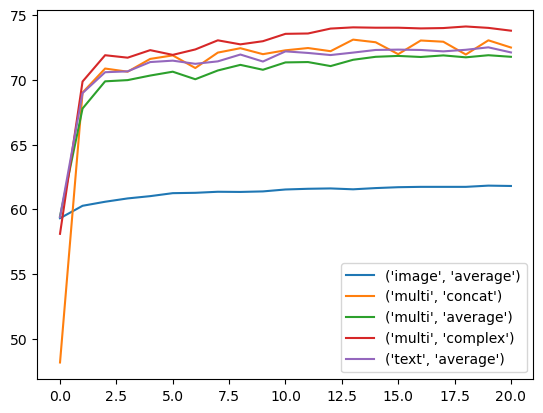

val_img_txt


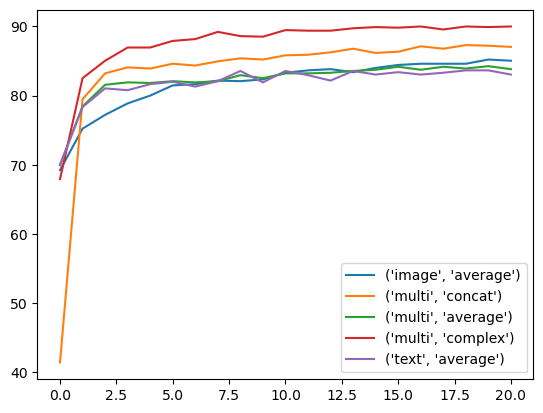

val_txt_only


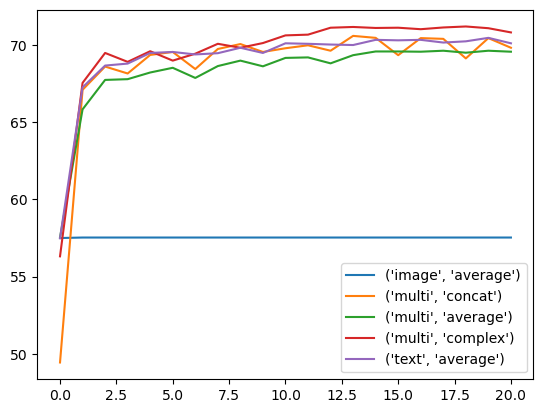

val_unseen_img


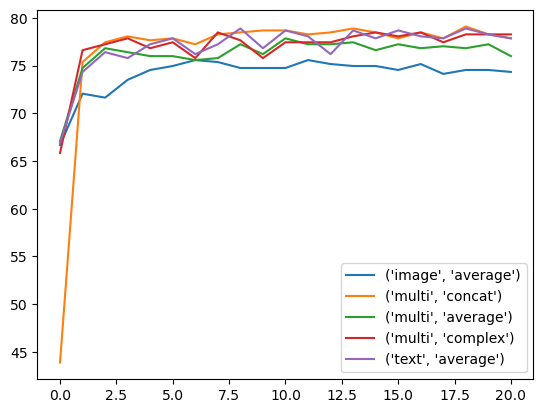

In [49]:
demonstration(hyperdict)

('image', 'average')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.6139    0.9882    0.7573     29306
         1.0     0.8379    0.0896    0.1619     20010

    accuracy                         0.6236     49316
   macro avg     0.7259    0.5389    0.4596     49316
weighted avg     0.7047    0.6236    0.5157     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.6138    0.9902    0.7579     20463
         1.0     0.8676    0.0933    0.1684     14058

    accuracy                         0.6250     34521
   macro avg     0.7407    0.5417    0.4631     34521
weighted avg     0.7172    0.6250    0.5178     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.6114    0.9836    0.7541      4400
         1.0     0.7736    0.0821    0.1484      2997

    accuracy                         0.6184      7397
   macro avg     0.6925    0.5329    0.4512

C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metr


    Overall Accuracy: 62.36
    Training Set Accuracy: 62.50
    Validation Set Accuracy: 61.84
    Validation Set with both Images and Texts: 85.22
    Validation Set with only Texts: 57.53
    Validation Set with unseen Images: 74.53
    
Test Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.6139    0.9882    0.7573     29306
         1.0     0.8379    0.0896    0.1619     20010

    accuracy                         0.6236     49316
   macro avg     0.7259    0.5389    0.4596     49316
weighted avg     0.7047    0.6236    0.5157     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.6138    0.9902    0.7579     20463
         1.0     0.8676    0.0933    0.1684     14058

    accuracy                         0.6250     34521
   macro avg     0.7407    0.5417    0.4631     34521
weighted avg     0.7172    0.6250    0.5178     34521

Validation Set:
              precision    recall  f1-score   s

C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metr

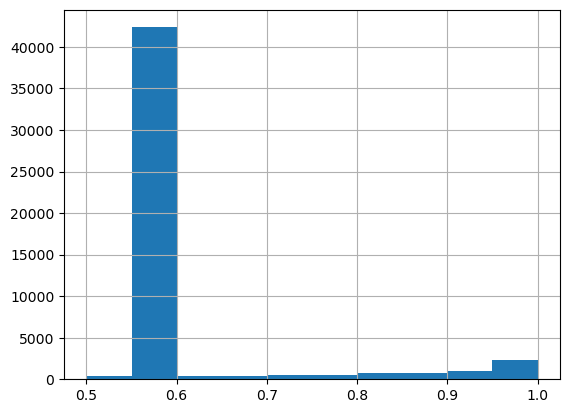

('multi', 'concat')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.8051    0.7296    0.7655     29306
         1.0     0.6518    0.7413    0.6936     20010

    accuracy                         0.7343     49316
   macro avg     0.7284    0.7354    0.7296     49316
weighted avg     0.7429    0.7343    0.7363     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.8076    0.7336    0.7688     20463
         1.0     0.6578    0.7456    0.6990     14058

    accuracy                         0.7385     34521
   macro avg     0.7327    0.7396    0.7339     34521
weighted avg     0.7466    0.7385    0.7404     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.8032    0.7255    0.7624      4400
         1.0     0.6471    0.7391    0.6900      2997

    accuracy                         0.7310      7397
   macro avg     0.7252    0.7323    0.7262 

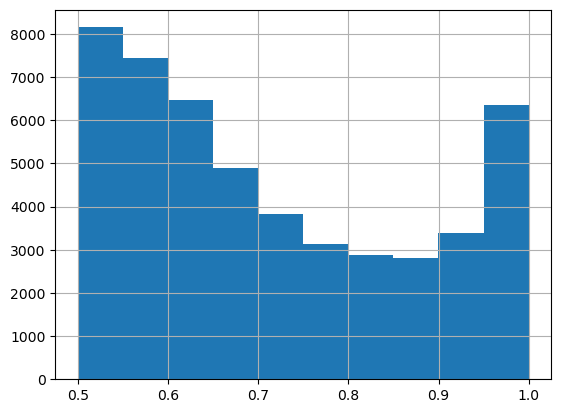

('multi', 'average')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.7728    0.7595    0.7661     29306
         1.0     0.6565    0.6731    0.6647     20010

    accuracy                         0.7244     49316
   macro avg     0.7147    0.7163    0.7154     49316
weighted avg     0.7256    0.7244    0.7250     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.7753    0.7638    0.7695     20463
         1.0     0.6634    0.6777    0.6705     14058

    accuracy                         0.7287     34521
   macro avg     0.7193    0.7208    0.7200     34521
weighted avg     0.7297    0.7287    0.7292     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.7694    0.7532    0.7612      4400
         1.0     0.6485    0.6687    0.6585      2997

    accuracy                         0.7189      7397
   macro avg     0.7090    0.7109    0.7098

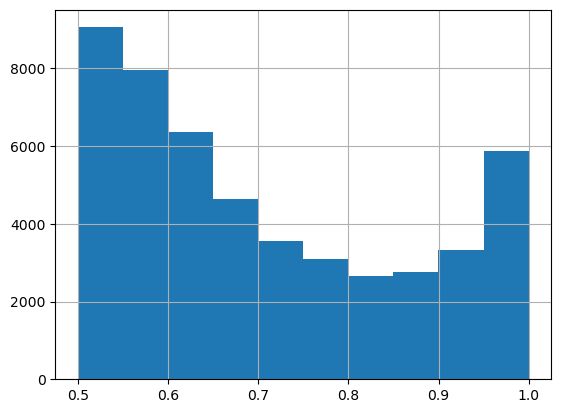

('multi', 'complex')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.8446    0.8008    0.8221     29306
         1.0     0.7288    0.7842    0.7555     20010

    accuracy                         0.7940     49316
   macro avg     0.7867    0.7925    0.7888     49316
weighted avg     0.7976    0.7940    0.7951     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.8668    0.8226    0.8441     20463
         1.0     0.7596    0.8160    0.7868     14058

    accuracy                         0.8199     34521
   macro avg     0.8132    0.8193    0.8155     34521
weighted avg     0.8232    0.8199    0.8208     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.7989    0.7548    0.7762      4400
         1.0     0.6670    0.7211    0.6930      2997

    accuracy                         0.7411      7397
   macro avg     0.7329    0.7379    0.7346

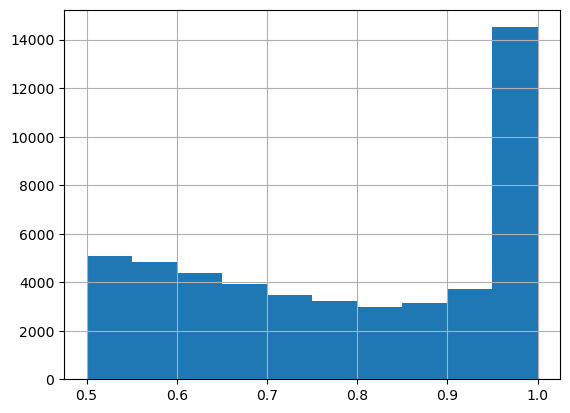

('text', 'average')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.7860    0.7696    0.7777     29306
         1.0     0.6726    0.6931    0.6827     20010

    accuracy                         0.7386     49316
   macro avg     0.7293    0.7314    0.7302     49316
weighted avg     0.7400    0.7386    0.7392     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.7918    0.7766    0.7841     20463
         1.0     0.6836    0.7028    0.6931     14058

    accuracy                         0.7465     34521
   macro avg     0.7377    0.7397    0.7386     34521
weighted avg     0.7478    0.7465    0.7471     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.7751    0.7575    0.7662      4400
         1.0     0.6555    0.6773    0.6662      2997

    accuracy                         0.7250      7397
   macro avg     0.7153    0.7174    0.7162 

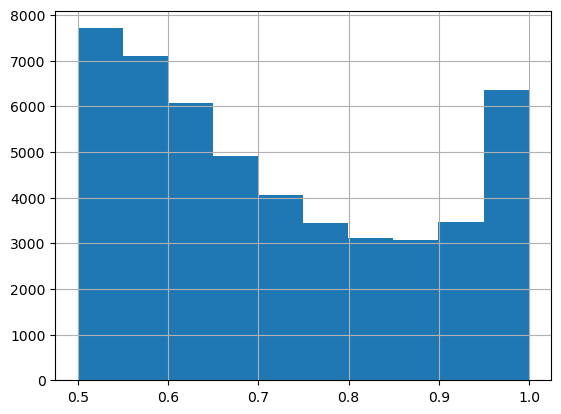

In [50]:
perform_results['O2'] = statistics_F1(hyperdict, stored_data, df, labs, subfolder='002/')

## Zero-shot Classification with Embeddings

In [51]:
embeddings = {}
for v in ['O1', 'O2']:
    embeddings[v] = {}
    for l in ['L2', 'L1', 'L0']:
        embeddings[v][l] = {}
        for t in ['val', 'test']:
            embeddings[v][l][t] = {}

In [52]:
embeddings

{'O1': {'L2': {'val': {}, 'test': {}},
  'L1': {'val': {}, 'test': {}},
  'L0': {'val': {}, 'test': {}}},
 'O2': {'L2': {'val': {}, 'test': {}},
  'L1': {'val': {}, 'test': {}},
  'L0': {'val': {}, 'test': {}}}}

### Option 1

In [53]:
args

Namespace(model_state_file='MLP_classifier.pth', save_dir='model_storage/CLIP/', embedding_size=512, early_stopping_criteria=20, num_epochs=20, seed=42, batch_size=32, embedding_type='text', fusion_type='average', hidden_dim=128, learning_rate=5e-05, l2=1e-05, dropout_p=0.1, catch_keyboard_interrupt=True, device='cuda', cuda=True, verbose=True)

In [54]:
args.embedding_type = 'multi'
args.fusion_type = 'complex'

In [55]:
classifier = MLPClassifier(embedding_size=args.embedding_size, 
                        hidden_dim=args.hidden_dim, 
                        embedding_type=args.embedding_type, 
                        fusion_type=args.fusion_type,
                        num_classes=len(labels), 
                        dropout_p=args.dropout_p).to(args.device)
classifier.load_state_dict(torch.load(args.save_dir + '001/' + args.embedding_type + "_" + args.fusion_type + "_" + args.model_state_file, map_location=torch.device('cpu')))
classifier.eval()

MLPClassifier(
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (fc_concat): Linear(in_features=1024, out_features=128, bias=True)
  (fc_complex): Linear(in_features=2560, out_features=1024, bias=True)
)

In [56]:
new_emb = F.relu(classifier.dropout(classifier.fc_concat(F.relu(classifier.dropout(classifier.fc_complex(prepare_embedding(stored_data, args.embedding_type, args.fusion_type)))))))
new_emb.shape

torch.Size([49316, 128])

In [57]:
labs = {}
labs['txt_emb'] = stored_data['lab_emb']
empty_img_emb = stored_data['empty_img_emb']
labs['img_emb'] = torch.vstack([empty_img_emb] * labs['txt_emb'].shape[0])

In [58]:
labs['img_emb'].shape

torch.Size([2, 512])

In [59]:
new_lab_emb = F.relu(classifier.dropout(classifier.fc_concat(F.relu(classifier.dropout(classifier.fc_complex(prepare_embedding(labs, args.embedding_type, args.fusion_type)))))))
new_lab_emb.shape

torch.Size([2, 128])

In [60]:
MUL_LAB = util.cos_sim(new_lab_emb, new_emb)
pred_MUL = torch.argmax(MUL_LAB[:2,:], dim=0).float()
lab = torch.tensor(np.array(df['skepticism'])).to('cuda').float()
print('Zero-shot using new multi-modal embedding:')
embeddings['O1']['L2']['val'] = evaluate_dataset_F1(df, pred_MUL)
print('Zero-shot using new multi-modal embedding (test):')
embeddings['O1']['L2']['test'] = evaluate_dataset_F1(df, pred_MUL, val_set='test')

Zero-shot using new multi-modal embedding:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.7579    0.7920    0.7745     29306
         1.0     0.6738    0.6294    0.6509     20010

    accuracy                         0.7260     49316
   macro avg     0.7158    0.7107    0.7127     49316
weighted avg     0.7238    0.7260    0.7244     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.7682    0.7986    0.7831     20463
         1.0     0.6889    0.6493    0.6685     14058

    accuracy                         0.7378     34521
   macro avg     0.7286    0.7239    0.7258     34521
weighted avg     0.7359    0.7378    0.7364     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.7418    0.7827    0.7617      4400
         1.0     0.6529    0.5999    0.6253      2997

    accuracy                         0.7087      7397
   macro avg     0.6973    0.6913    0

In [61]:
new_emb = F.relu(classifier.dropout(classifier.fc_complex(prepare_embedding(stored_data, args.embedding_type, args.fusion_type))))
new_emb.shape

torch.Size([49316, 1024])

In [62]:
new_lab_emb = F.relu(classifier.dropout(classifier.fc_complex(prepare_embedding(labs, args.embedding_type, args.fusion_type))))
new_lab_emb.shape

torch.Size([2, 1024])

In [63]:
MUL_LAB = util.cos_sim(new_lab_emb, new_emb)
pred_MUL = torch.argmax(MUL_LAB[:2,:], dim=0).float()
lab = torch.tensor(np.array(df['skepticism'])).to('cuda').float()
print('Zero-shot using new multi-modal embedding:')
embeddings['O1']['L1']['val'] = evaluate_dataset_F1(df, pred_MUL)
print('Zero-shot using new multi-modal embedding (test):')
embeddings['O1']['L1']['test'] = evaluate_dataset_F1(df, pred_MUL, val_set='test')

Zero-shot using new multi-modal embedding:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.6283    0.8658    0.7282     29306
         1.0     0.5598    0.2500    0.3457     20010

    accuracy                         0.6159     49316
   macro avg     0.5941    0.5579    0.5369     49316
weighted avg     0.6005    0.6159    0.5730     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.6253    0.8635    0.7253     20463
         1.0     0.5539    0.2468    0.3414     14058

    accuracy                         0.6123     34521
   macro avg     0.5896    0.5551    0.5334     34521
weighted avg     0.5962    0.6123    0.5690     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.6362    0.8757    0.7370      4400
         1.0     0.5921    0.2649    0.3661      2997

    accuracy                         0.6282      7397
   macro avg     0.6142    0.5703    0

In [64]:
new_emb = prepare_embedding(stored_data, args.embedding_type, args.fusion_type)
new_emb.shape

torch.Size([49316, 2560])

In [65]:
new_lab_emb = prepare_embedding(labs, args.embedding_type, args.fusion_type)
new_lab_emb.shape

torch.Size([2, 2560])

In [66]:
MUL_LAB = util.cos_sim(new_lab_emb, new_emb)
pred_MUL = torch.argmax(MUL_LAB[:2,:], dim=0).float()
lab = torch.tensor(np.array(df['skepticism'])).to('cuda').float()
print('Zero-shot using new multi-modal embedding:')
embeddings['O1']['L0']['val'] = evaluate_dataset_F1(df, pred_MUL)
print('Zero-shot using new multi-modal embedding (test):')
embeddings['O1']['L0']['test'] = evaluate_dataset_F1(df, pred_MUL, val_set='test')

Zero-shot using new multi-modal embedding:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.6476    0.2473    0.3579     29306
         1.0     0.4214    0.8029    0.5527     20010

    accuracy                         0.4727     49316
   macro avg     0.5345    0.5251    0.4553     49316
weighted avg     0.5558    0.4727    0.4370     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.6414    0.2436    0.3531     20463
         1.0     0.4214    0.8017    0.5524     14058

    accuracy                         0.4709     34521
   macro avg     0.5314    0.5227    0.4528     34521
weighted avg     0.5518    0.4709    0.4343     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.6618    0.2659    0.3794      4400
         1.0     0.4262    0.8005    0.5562      2997

    accuracy                         0.4825      7397
   macro avg     0.5440    0.5332    0

### Option 2

In [67]:
classifier = MLPClassifier(embedding_size=args.embedding_size, 
                        hidden_dim=args.hidden_dim, 
                        embedding_type=args.embedding_type, 
                        fusion_type=args.fusion_type,
                        num_classes=len(labels), 
                        dropout_p=args.dropout_p).to(args.device)
classifier.load_state_dict(torch.load(args.save_dir + '002/' + args.embedding_type + "_" + args.fusion_type + "_" + args.model_state_file,map_location=torch.device('cpu')))
classifier.eval()

MLPClassifier(
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (fc_concat): Linear(in_features=1024, out_features=128, bias=True)
  (fc_complex): Linear(in_features=2560, out_features=1024, bias=True)
)

In [68]:
new_emb = F.relu(classifier.dropout(classifier.fc_concat(F.relu(classifier.dropout(classifier.fc_complex(prepare_embedding(stored_data, args.embedding_type, args.fusion_type)))))))
new_emb.shape

torch.Size([49316, 128])

In [69]:
new_lab_emb = F.relu(classifier.dropout(classifier.fc_concat(F.relu(classifier.dropout(classifier.fc_complex(prepare_embedding(labs, args.embedding_type, args.fusion_type)))))))
new_lab_emb.shape

torch.Size([2, 128])

In [70]:
MUL_LAB = util.cos_sim(new_lab_emb, new_emb)
pred_MUL = torch.argmax(MUL_LAB[:2,:], dim=0).float()
lab = torch.tensor(np.array(df['skepticism'])).to('cuda').float()
print('Zero-shot using new multi-modal embedding:')
embeddings['O2']['L2']['val'] = evaluate_dataset_F1(df, pred_MUL)
print('Zero-shot using new multi-modal embedding (test):')
embeddings['O2']['L2']['test'] = evaluate_dataset_F1(df, pred_MUL, val_set='test')

Zero-shot using new multi-modal embedding:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.8708    0.7593    0.8113     29306
         1.0     0.7032    0.8350    0.7634     20010

    accuracy                         0.7900     49316
   macro avg     0.7870    0.7972    0.7873     49316
weighted avg     0.8028    0.7900    0.7918     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.8930    0.7813    0.8334     20463
         1.0     0.7307    0.8637    0.7917     14058

    accuracy                         0.8149     34521
   macro avg     0.8118    0.8225    0.8125     34521
weighted avg     0.8269    0.8149    0.8164     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.8247    0.7175    0.7674      4400
         1.0     0.6517    0.7761    0.7085      2997

    accuracy                         0.7412      7397
   macro avg     0.7382    0.7468    0

In [71]:
new_emb = F.relu(classifier.dropout(classifier.fc_complex(prepare_embedding(stored_data, args.embedding_type, args.fusion_type))))
new_emb.shape

torch.Size([49316, 1024])

In [72]:
new_lab_emb = F.relu(classifier.dropout(classifier.fc_complex(prepare_embedding(labs, args.embedding_type, args.fusion_type))))
new_lab_emb.shape

torch.Size([2, 1024])

In [73]:
MUL_LAB = util.cos_sim(new_lab_emb, new_emb)
pred_MUL = torch.argmax(MUL_LAB[:2,:], dim=0).float()
lab = torch.tensor(np.array(df['skepticism'])).to('cuda').float()
print('Zero-shot using new multi-modal embedding:')
embeddings['O2']['L1']['val'] = evaluate_dataset_F1(df, pred_MUL)
print('Zero-shot using new multi-modal embedding (test):')
embeddings['O2']['L1']['test'] = evaluate_dataset_F1(df, pred_MUL, val_set='test')

Zero-shot using new multi-modal embedding:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.7304    0.7667    0.7481     29306
         1.0     0.6315    0.5855    0.6076     20010

    accuracy                         0.6932     49316
   macro avg     0.6809    0.6761    0.6779     49316
weighted avg     0.6903    0.6932    0.6911     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.7343    0.7696    0.7515     20463
         1.0     0.6394    0.5946    0.6162     14058

    accuracy                         0.6984     34521
   macro avg     0.6868    0.6821    0.6839     34521
weighted avg     0.6957    0.6984    0.6964     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.7235    0.7661    0.7442      4400
         1.0     0.6242    0.5702    0.5960      2997

    accuracy                         0.6868      7397
   macro avg     0.6739    0.6682    0

In [74]:
new_emb = prepare_embedding(stored_data, args.embedding_type, args.fusion_type)
new_emb.shape

torch.Size([49316, 2560])

In [75]:
new_lab_emb = prepare_embedding(labs, args.embedding_type, args.fusion_type)
new_lab_emb.shape

torch.Size([2, 2560])

In [76]:
MUL_LAB = util.cos_sim(new_lab_emb, new_emb)
pred_MUL = torch.argmax(MUL_LAB[:2,:], dim=0).float()
lab = torch.tensor(np.array(df['skepticism'])).to('cuda').float()
print('Zero-shot using new multi-modal embedding:')
embeddings['O2']['L0']['val'] = evaluate_dataset_F1(df, pred_MUL)
print('Zero-shot using new multi-modal embedding (test):')
embeddings['O2']['L0']['test'] = evaluate_dataset_F1(df, pred_MUL, val_set='test')

Zero-shot using new multi-modal embedding:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.6476    0.2473    0.3579     29306
         1.0     0.4214    0.8029    0.5527     20010

    accuracy                         0.4727     49316
   macro avg     0.5345    0.5251    0.4553     49316
weighted avg     0.5558    0.4727    0.4370     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.6414    0.2436    0.3531     20463
         1.0     0.4214    0.8017    0.5524     14058

    accuracy                         0.4709     34521
   macro avg     0.5314    0.5227    0.4528     34521
weighted avg     0.5518    0.4709    0.4343     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.6618    0.2659    0.3794      4400
         1.0     0.4262    0.8005    0.5562      2997

    accuracy                         0.4825      7397
   macro avg     0.5440    0.5332    0

In [77]:
results = {}
results['fusion'] = perform_results
results['new_embedding'] = embeddings

In [84]:
import pickle
with open(args.result_dir + 'results_F1.pkl', "wb") as fOut:
    pickle.dump(results, fOut, protocol=pickle.HIGHEST_PROTOCOL)